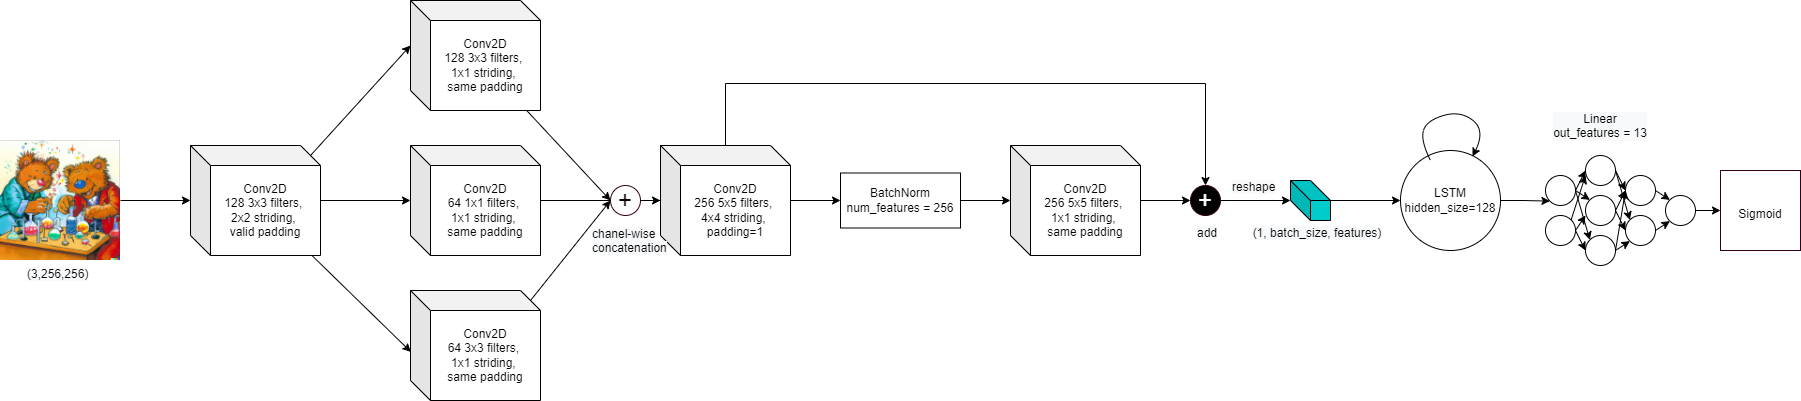

In [ ]:
import torch
from torch import nn
from torchvision import models
from torchsummary import summary

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

response = requests.get("https://cdn.openai.com/dall-e-2/demos/text2im/teddy_bears/mad_scientists/saturday-morning-cartoon/0.jpg")
image = Image.open(BytesIO(response.content)).convert('RGB')
image = image.resize((256, 256))
image = np.rollaxis(np.array(image), 2, 0)

In [ ]:
image.shape

(3, 256, 256)

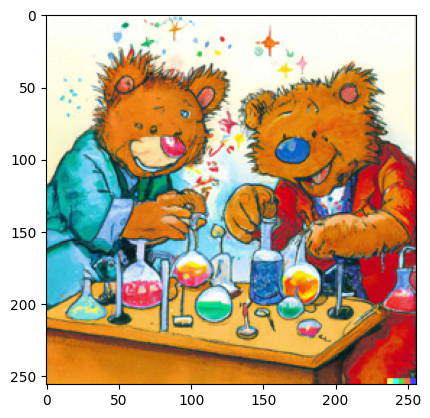

In [ ]:
plt.imshow(np.moveaxis(image, 0,-1))

In [ ]:
#Simple pre-processing
input_image = torch.from_numpy(image)
input_image = torch.unsqueeze(input_image, dim=0)
input_image.size()

# [1, 3, 256, 256]
# 1 = batch size
# 3 = number of channels, RGB
# 256, 256 = dimentions of the image

torch.Size([1, 3, 256, 256])

In [ ]:
class ImageToText(nn.Module):
    def __init__(self):
        super(ImageToText, self).__init__()

        # output_size = ((input_size - kernel_size + 2 * padding) / (stride)) + 1

        # A convolutional layer is a fundamental building block in a Convolutional Neural Network (CNN).
        # It is designed to efficiently process grid-like data, such as images, by applying convolutional operations.

        # in_channel = 3 cunku image'dan gelen number of channels = 3
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 128, kernel_size = (3, 3), stride = (2, 2), padding = 'valid')

        # in_channels = 128 cunku conv1'den gelen out_channels = 128
        self.conv2a = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3, 3), stride = (1, 1), padding = 'same')
        self.conv2b = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = (1, 1), stride = (1, 1), padding = 'same')
        self.conv2c = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = (3, 3), stride = (1, 1), padding = 'same')

        # in_channels = 256 cunku bundan onceki birlestirdigimiz 3 layer(conv2a,conv2b,conv2c'nin out_channel toplami 256 yapiyor)
        self.conv3 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = (5, 5), stride = (4, 4), padding = 1)

        #batch_norm, increases the training speed and efficiency by normalizing the input from layers. It operates in mini batches
        self.batch_norm = nn.BatchNorm2d(num_features = 256)

        # in_channels is 256 because num_features from batch_norm is 256
        self.conv4 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = (5, 5), stride = (1, 1), padding = 'same')

        # LSTM is type of RNN architecture that captures and remembers the long term dependencies in sequential data.
        # LSTM consists of memory cells. memory cells allows LSTM to retrieve and store data in long periods.
        # hidden_size determines the number of memory cells in LSTM. The higher the hidden size is, the better LSTM can capture complex patterns.
        # But it increases the computational cost.

        # LSTM'in neden 32*32 boyutlarına sahip olduğunu anlamadım.  !!!!!
        # input_size = 256, because out_channel from conv4 = 256 (?)
        self.lstm = nn.LSTM(input_size = 256*32*32, hidden_size = 128)


        # Linear layer also known as fully connected layer, connects every element in the input tensor to every element in the output tensor
        # This linear layer is typically used to transform the features learned by the preceding layers into the final output of the network.
        # The number of output features (13) often corresponds to the number of classes in a classification task.

        self.fc_out = nn.Linear(in_features = 128, out_features = 13)

        self.sigmoid = nn.Sigmoid() # Last layer of classification task

    def forward(self, image):
        batch_size = image.size(0)

        features = self.conv1(image) # conv1 layer'a degerler image'dan geliyor.
        print('conv1', features.shape)

        # Bu uc layer icin butun degerler bir onceki layer olan features'dan geliyor bu yuzden deger kismina onu yaziyoruz.
        # Boylece deger olarak conv2a = conv1 + conv2a , conv2b = conv1 + conv2b, conv2c = conv1 + conv2c

        conv2a = self.conv2a(features)
        print('conv2a', conv2a.shape)
        conv2b = self.conv2b(features)
        print('conv2b', conv2b.shape)
        conv2c = self.conv2c(features)
        print('conv2c', conv2c.shape)

        # torch.cat tensorlari birlestirmemize olanak saglar. Eger 2 boyutlu tensorlarimiz varsa(ki bu durumda oyle), dim ya 0 ya da 1 olabilir.
        # Eger 3 boyutluysa, 0,1,2 olabilir. dim eger 0 ise, tensorler birbirinin ustune stack olarak birlesir. (vertical concatenation)
        # dim = 1 ise tensorler yan yana birlesir. (Channel-wise concatenation) ya da (Horizontal-concatenation)
        # dim = 2 ya da ustu ise tensorler boyutlar boyunca birlesir. (Depth Concatenation)
        # Ama en yaygini dim = 1 seklinde birlesim

        combined = torch.cat((conv2a,conv2b,conv2c), dim=1)
        print('combined', combined.shape)

        combined = self.conv3(combined) # Burada combined ile bundan sonraki conv3 tensoru birlestirip combined adi altinda devam ediyoruz
        print('conv3' , combined.shape)

        norm = self.batch_norm(combined)
        print('norm', norm.shape)

        conv4 = self.conv4(norm)
        print('conv4', conv4.shape)

        features = conv4 + combined # model semasinda belirtildigi gibi add islemi yapildi. Ama neden features isminde topladik bilmiyorum.
        # Not : features ismini degistirip denedim, sonuc degismedi. İlla features olmasina gerek yok galiba

        print('add', features.shape)

        # The view function in PyTorch is used to reshape a tensor.
        # 3. parametrede 256*32*32 numaralarini verdik cunku bundan sonra gelen lstm layerin input_size = 256*32*32
        features = features.view(1, batch_size, 256*32*32)
        print('flatten', features.shape)

        out, hidden_lstm = self.lstm(features) # lstm'nin iki tane outputu vardır. Biri output digeri ise hidden state
        print('lstm', out.shape)

        # ilk once out = lstm den aliyoruz daha sonra out = fc_out(Linear layer)'a ekliyoruz
        out = self.fc_out(out)
        print('out', out.shape)

        predictions = self.sigmoid(out) # En sonunda da hepsini sigmoid function'a bagliyoruz.
        print('sig', predictions.shape)



        return predictions #rename your last output as predictions, or change the name here

In [ ]:
imagetotext = ImageToText()

output = imagetotext(input_image.float())

output.size()


conv1 torch.Size([1, 128, 127, 127])
conv2a torch.Size([1, 128, 127, 127])
conv2b torch.Size([1, 64, 127, 127])
conv2c torch.Size([1, 64, 127, 127])
combined torch.Size([1, 256, 127, 127])
conv3 torch.Size([1, 256, 32, 32])
norm torch.Size([1, 256, 32, 32])
conv4 torch.Size([1, 256, 32, 32])
add torch.Size([1, 256, 32, 32])
flatten torch.Size([1, 1, 262144])
lstm torch.Size([1, 1, 128])
out torch.Size([1, 1, 13])
sig torch.Size([1, 1, 13])


torch.Size([1, 1, 13])